In [1]:
from math import pi

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import pickle
import torch
import torchaudio
import torch.nn.functional as F

%load_ext autoreload
%autoreload 2
%matplotlib inline

from dstft import DSTFT, ADSTFT

device = "cpu" #"cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(1802);

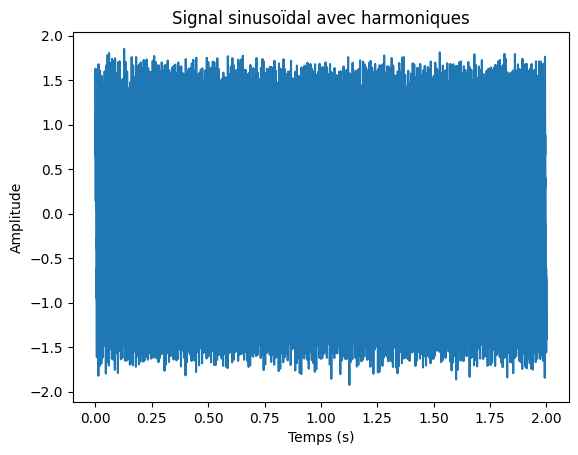

In [2]:
# Définition des paramètres du signal
sr = 8_000
T = 2
t = np.arange(0, T, 1 / sr)
f0 = 150
a = 1
p = 5

x = a * np.sin(2 * np.pi * f0 * t)
for i in range(2, p + 1):
    x += a / i * np.sin(2 * np.pi * i * f0 * t)
x += np.random.normal(0, 0.1, len(t))

# Affichage du signal
plt.plot(t, x)
plt.xlabel("Temps (s)")
plt.ylabel("Amplitude")
plt.title("Signal sinusoïdal avec harmoniques")

plt.show()

x = torch.tensor(x, dtype=torch.float32, device=device)

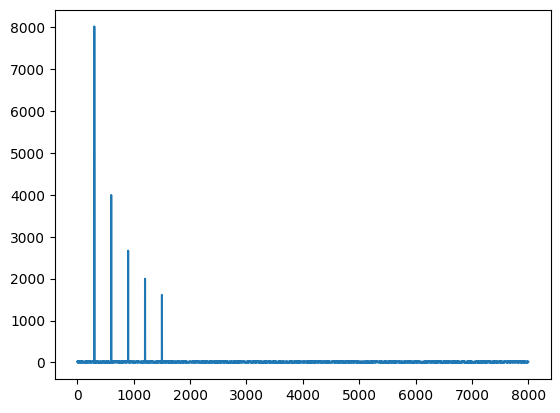

In [3]:
spectrum = torch.fft.rfft(x)
plt.plot(torch.abs(spectrum))

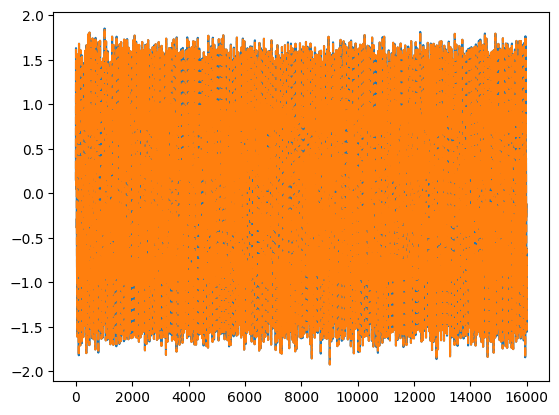

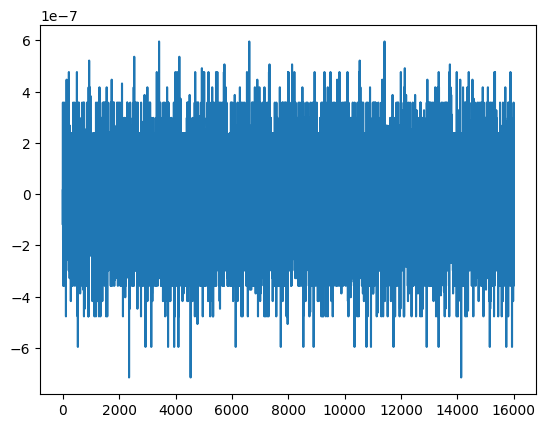

In [4]:
x_hat = torch.fft.irfft(spectrum)
plt.plot(x_hat, label="x_hat")
plt.plot(x, linestyle="--", label="x")

plt.figure()
plt.plot(x - x_hat, label="diff")

In [5]:
n_fft = 1_000
win_length = n_fft
hop_length = 256

torch.Size([501, 63])


/home/maxime/miniforge3/envs/spymon/lib/python3.11/site-packages/torch/functional.py:709: UserWarning: A window was not provided. A rectangular window will be applied,which is known to cause spectral leakage. Other windows such as torch.hann_window or torch.hamming_window can are recommended to reduce spectral leakage.To suppress this warning and use a rectangular window, explicitly set `window=torch.ones(n_fft, device=<device>)`. (Triggered internally at /pytorch/aten/src/ATen/native/SpectralOps.cpp:836.)
  return _VF.stft(  # type: ignore[attr-defined]


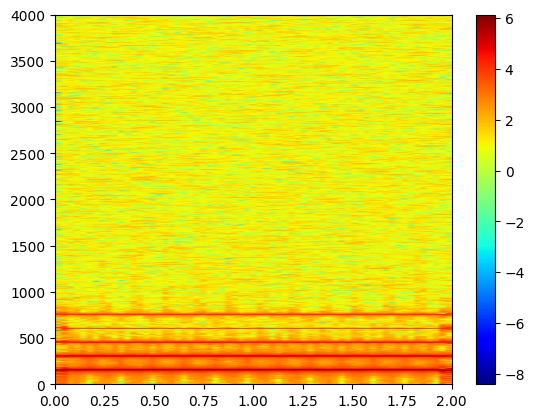

In [6]:
spectrogram = torch.stft(x, n_fft=n_fft, hop_length=hop_length, return_complex=True)
print(spectrogram.shape)
plt.imshow(
    torch.log(torch.abs(spectrogram)).cpu().numpy(),
    aspect="auto",
    origin="lower",
    cmap="jet",
    extent=(0, T, 0, sr / 2),
)
plt.colorbar()

/tmp/ipykernel_68679/112356221.py:1: UserWarning: A window was not provided. A rectangular window will be applied.Please provide the same window used by stft to make the inversion lossless.To suppress this warning and use a rectangular window, explicitly set `window=torch.ones(n_fft, device=<device>)`. (Triggered internally at /pytorch/aten/src/ATen/native/SpectralOps.cpp:1023.)
  x_hat = torch.istft(spectrogram, hop_length=256, length=len(x), n_fft=1_000)


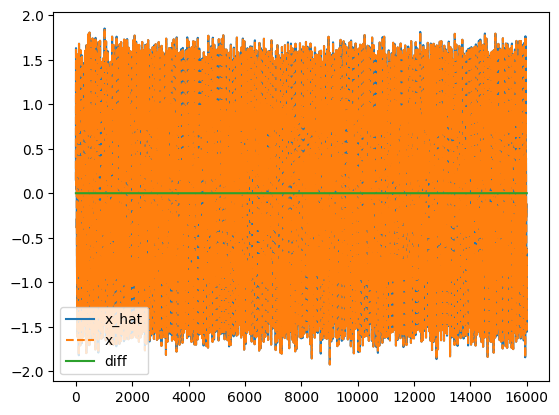

In [7]:
x_hat = torch.istft(spectrogram, hop_length=256, length=len(x), n_fft=1_000)

plt.plot(x_hat, label="x_hat")
plt.plot(x, linestyle="--", label="x")
plt.plot(x - x_hat, label="diff")
plt.legend()

In [8]:
x = torch.unsqueeze(x, 0)

interactive(children=(IntSlider(value=0, description='frame', max=62), Output()), _dom_classes=('widget-intera…

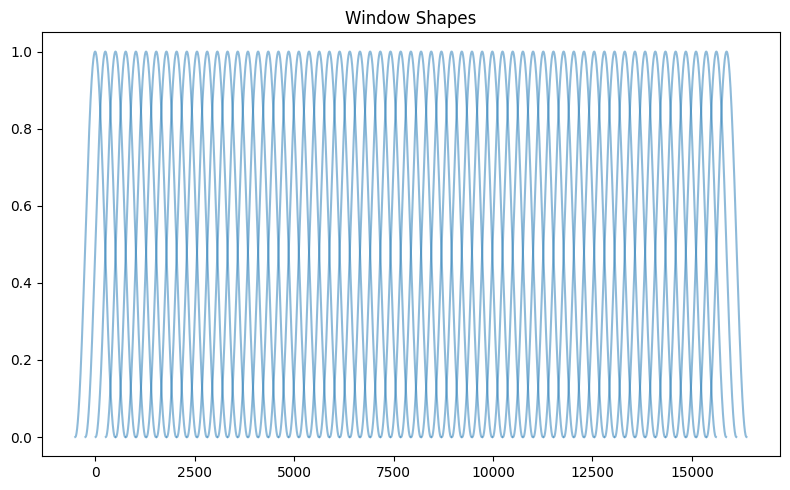

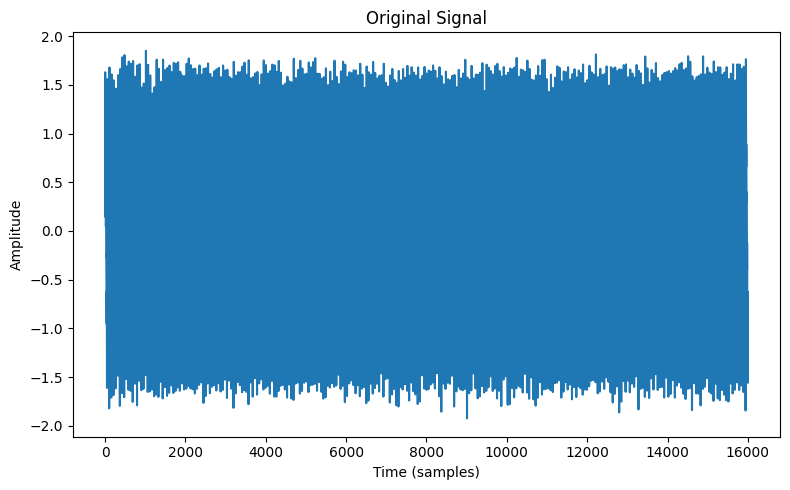

tensor(126568.6562)


interactive(children=(IntSlider(value=0, description='frame', max=62), Output()), _dom_classes=('widget-intera…

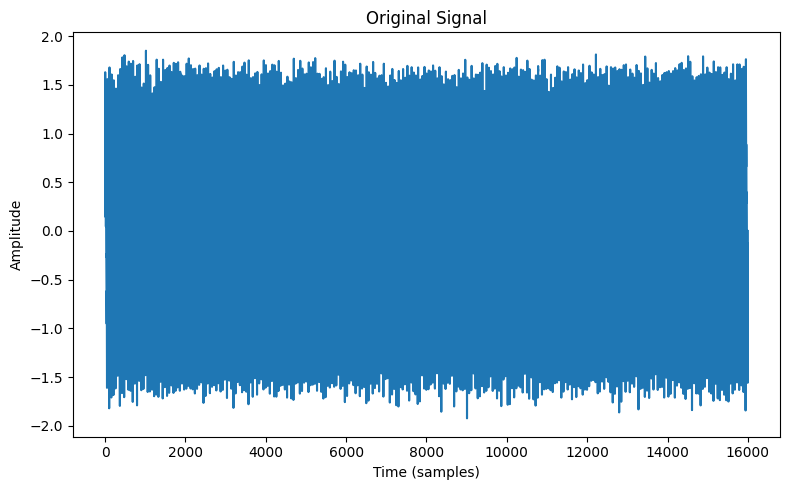

In [9]:
from dstft import DSTFT

dstft = DSTFT(
    x,
    win_length=win_length,
    support=n_fft,
    stride=hop_length,
    win_requires_grad=False,
    stride_requires_grad=False,
    win_p=None,
    stride_p=None,
)
spec, stft = dstft(x)

dstft.plot(spec, x, bar=True, weights=False, wins=True)
# plt.figure()
# dstft.plot(stft_ref.abs().unsqueeze(0), x, bar=True, weights=False, wins=True)


print(spec.sum())

x_hat = dstft.inverse_dstft(stft)

# x_hat = x_hat / x_hat.abs().max() * x.abs().max()
plt.figure()
plt.plot(x.squeeze().cpu().detach().numpy(), label="x")
plt.plot(x_hat.squeeze().cpu().detach().numpy(), label="x_hat", alpha=0.5)
plt.legend()

spectrum = torch.fft.rfft(x[0])
spectrum_hat = torch.fft.rfft(x_hat[0])
plt.figure()
plt.plot(torch.abs(spectrum), label="x")
plt.plot(torch.abs(spectrum_hat), alpha=0.5, label="x_hat")
plt.legend()

spec_hat, stft_hat = dstft(x_hat)

dstft.plot(spec_hat, x_hat, bar=True, weights=False, wins=False)

In [10]:
from scipy.io import loadmat

mat = loadmat("../data/fan_flutter.mat")["x"]
x = torch.from_numpy(mat).float().to(device)[:, 4_000:10_000].squeeze()

FileNotFoundError: [Errno 2] No such file or directory: '../data/fan_flutter.mat'

In [ ]:
n_fft = 1_024
win_length = 1_000
hop_length = 500

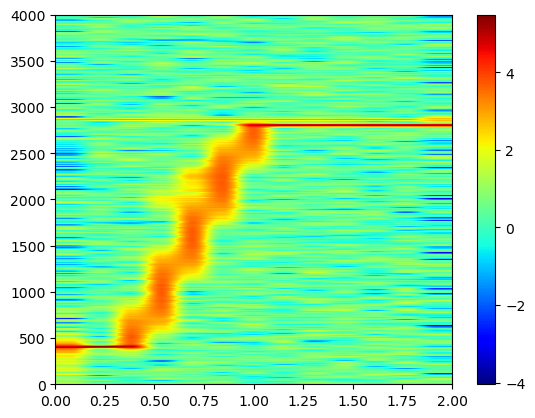

In [ ]:
stft_ref = torch.stft(
    x,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    return_complex=True,
    window=torch.hann_window(win_length).to(device),
)

plt.imshow(
    torch.log(torch.abs(stft_ref)).cpu().numpy(),
    aspect="auto",
    origin="lower",
    cmap="jet",
    extent=(0, T, 0, sr / 2),
)
plt.colorbar()

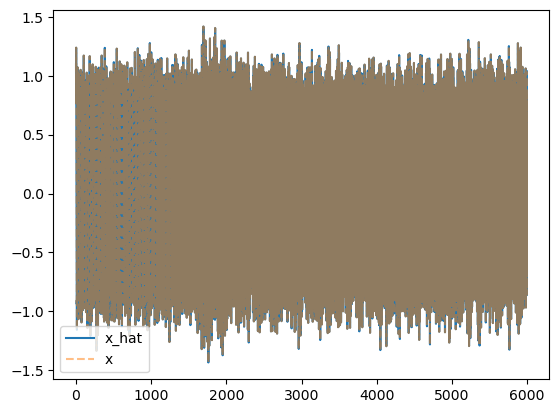

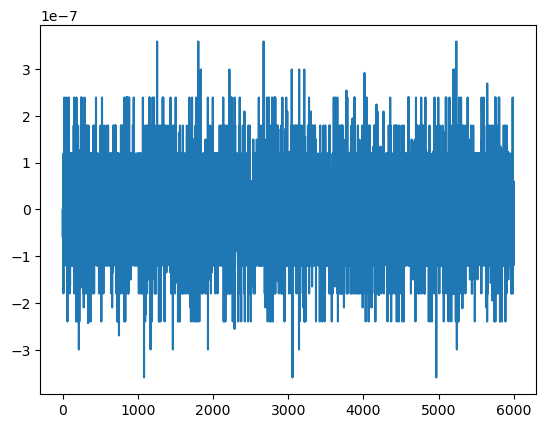

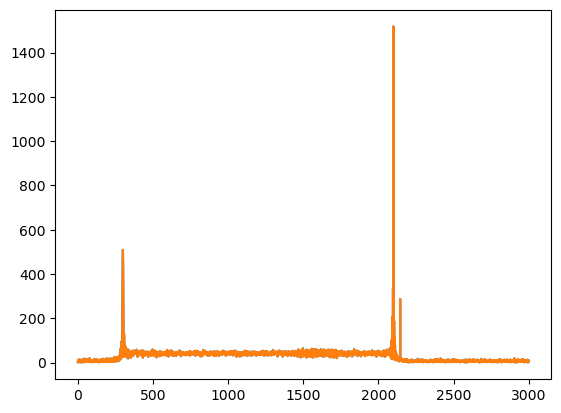

In [ ]:
x_hat = torch.zeros_like(x)
torch_istft = torch.istft(
    stft_ref,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    window=torch.hann_window(win_length).to(device),
)
x_hat[: torch_istft.shape[0]] = torch_istft

plt.plot(x_hat, label="x_hat")
plt.plot(x, linestyle="--", label="x", alpha=0.5)
plt.legend()

plt.figure()
plt.plot(x - x_hat, label="diff")

plt.figure()
spectrum = torch.fft.rfft(x)
spectrum_hat = torch.fft.rfft(x_hat)
plt.plot(torch.abs(spectrum))
plt.plot(torch.abs(spectrum_hat))

In [ ]:
x = torch.unsqueeze(x, 0)

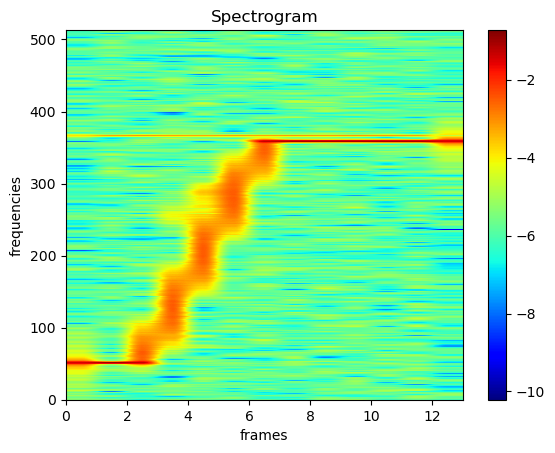

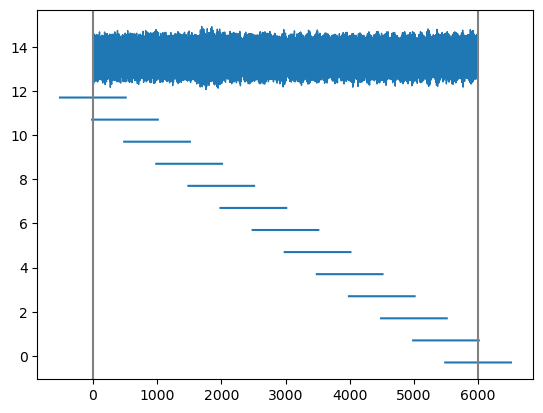

tensor(58.4890) tensor(29394.3379) tensor(502.5616)


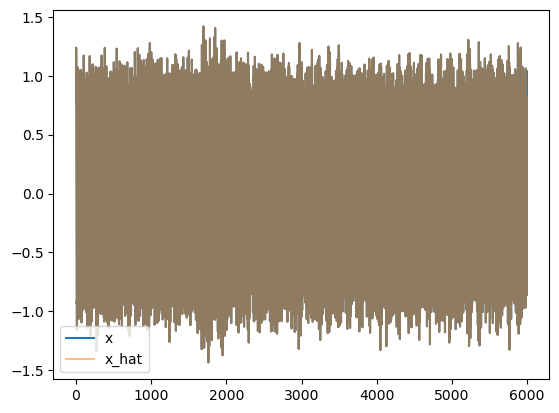

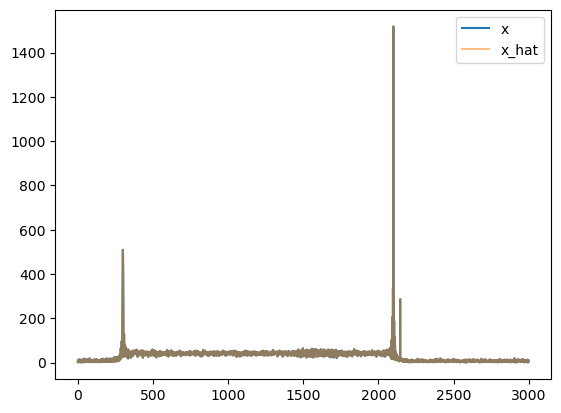

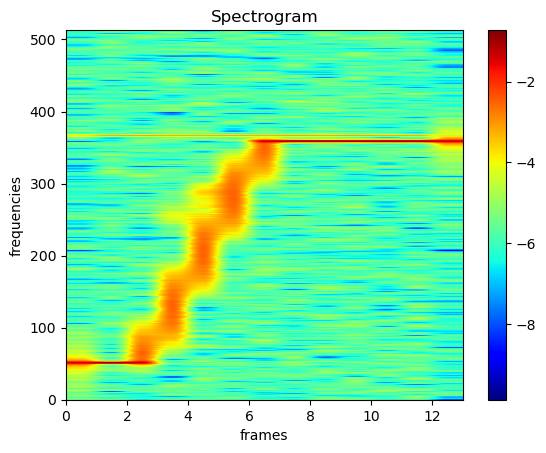

In [ ]:
from dstft import DSTFT

dstft = DSTFT(
    x,
    win_length=win_length,
    support=n_fft,
    stride=hop_length,
    win_requires_grad=False,
    stride_requires_grad=False,
    win_p=None,
    stride_p=None,
)
spec, stft = dstft(x)

dstft.plot(spec, x, bar=True, weights=False, wins=True)
# plt.figure()
# dstft.plot(stft_ref.abs().unsqueeze(0), x, bar=True, weights=False, wins=True)


print(spec.sum(), stft_ref.abs().sum(), stft_ref.abs().sum() / spec.sum())

x_hat = dstft.inverse_dstft(stft)

# x_hat = x_hat / x_hat.abs().max() * x.abs().max()
plt.figure()
plt.plot(x.squeeze().cpu().detach().numpy(), label="x")
plt.plot(x_hat.squeeze().cpu().detach().numpy(), label="x_hat", alpha=0.5)
plt.legend()

spectrum = torch.fft.rfft(x[0])
spectrum_hat = torch.fft.rfft(x_hat[0])
plt.figure()
plt.plot(torch.abs(spectrum), label="x")
plt.plot(torch.abs(spectrum_hat), alpha=0.5, label="x_hat")
plt.legend()

spec_hat, stft_hat = dstft(x_hat)

dstft.plot(spec_hat, x_hat, bar=True, weights=False, wins=False)

In [ ]:
dstft.tap_win.shape

torch.Size([1, 13, 1024])

torch.Size([1, 6000]) torch.Size([1, 6000]) torch.Size([1, 13, 1024])


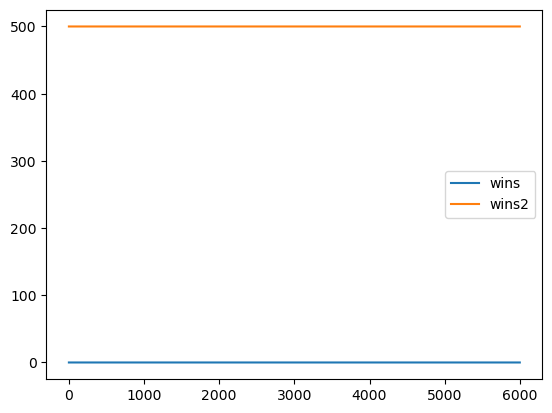

In [ ]:
fig, ax = plt.subplots()
wins = torch.zeros_like(x)
wins2 = torch.zeros_like(x)
print(wins.shape, wins2.shape, dstft.tap_win.shape)

for t in range(dstft.T):
    start_idx = max(0, int(dstft.frames[t]))
    end_idx = min(dstft.L, int(dstft.frames[t]) + dstft.N)
    start_dec = start_idx - int(dstft.frames[t])
    end_dec = end_idx - int(dstft.frames[t])
    #print(t, start_idx, end_idx, start_dec, end_dec)
    wins[:, start_idx:end_idx] += (
        dstft.tap_win[:, t, start_dec:end_dec].squeeze().detach().cpu()
    )

wins2[wins > 0] = 1 / wins[wins > 0]
plt.plot(wins[0], label='wins')
plt.plot(wins2[0], label='wins2')
plt.legend()

In [ ]:
idx = dstft.frames.floor()[:, None].expand((dstft.T, dstft.N)) + torch.arange(
    0, dstft.N, device=dstft.device
)
iwin = torch.zeros_like(dstft.tap_win)
tt = torch.ones_like(wins)

dstft.tap_win.shape, iwin.shape, idx.shape, wins.shape, wins2.shape, tt.shape

(torch.Size([1, 13, 1024]),
 torch.Size([1, 13, 1024]),
 torch.Size([13, 1024]),
 torch.Size([1, 6000]),
 torch.Size([1, 6000]),
 torch.Size([1, 6000]))

In [ ]:
#iwin[dstft.tap_win != 0] = 1 / dstft.tap_win[dstft.tap_win != 0]
#iwin[dstft.tap_win == 0] = 0

In [ ]:
iwin = torch.zeros_like(dstft.tap_win)
for t in range(dstft.T):
    start_idx = max(0, int(dstft.frames[t]))
    end_idx = min(dstft.L, int(dstft.frames[t]) + dstft.N)
    start_dec = start_idx - int(dstft.frames[t])
    end_dec = end_idx - int(dstft.frames[t])
    print(t, start_idx, end_idx, start_dec, end_dec)
    iwin[:, t, start_dec:end_dec] = (
        dstft.tap_win[:, t, start_dec:end_dec]
        / wins[:, start_idx:end_idx]
        * wins2[:, start_idx:end_idx]
    )

0 0 512 512 1024
1 0 1012 12 1024
2 488 1512 0 1024
3 988 2012 0 1024
4 1488 2512 0 1024
5 1988 3012 0 1024
6 2488 3512 0 1024
7 2988 4012 0 1024
8 3488 4512 0 1024
9 3988 5012 0 1024
10 4488 5512 0 1024
11 4988 6000 0 1012
12 5488 6000 0 512


In [ ]:
print(x_hat.abs().max() / x.abs().max())

tensor(1.0000)


In [ ]:
print(dstft.N / dstft.strides / 4)

tensor([0.5120])


In [ ]:
def entropy_loss(x):
    x1 = torch.reshape(x, (x.shape[0], -1))  # B, N
    probs = torch.div(x1.T, x1.sum(dim=-1)).T  # B, N
    entropy = -(
        probs * torch.clamp(torch.log(probs), min=torch.finfo(x.dtype).min)
    ).sum(
        dim=-1,
    )  # B
    return entropy.mean()

torch.Size([1, 4000]) cpu torch.float32
[0, 500, 1200, 1500, 2100, 2500, 3300, 3500, 4000]


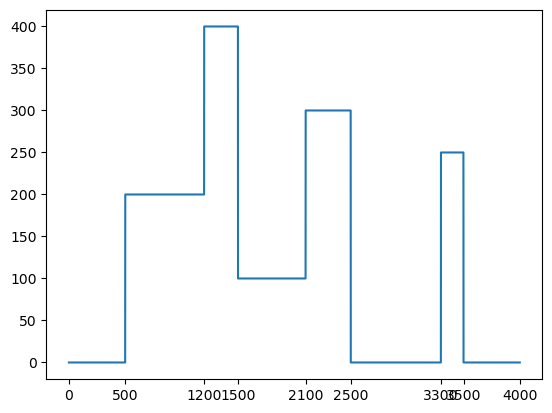

In [ ]:
sr = 1e3
sizes = [500, 700, 300, 600, 400, 800, 200, 500]
freqs = [0, 200, 400, 100, 300, 0, 250, 0]
f = freqs[0] * (torch.ones(sizes[0]) + 0.0 * torch.randn(sizes[0]))
for i in range(1, len(freqs)):
    f = torch.cat((
        f,
        freqs[i] * (torch.ones(sizes[i]) + 0.0 * torch.randn(sizes[i])),
    ))
f = f + 0.0 * torch.ones_like(f) * torch.randn_like(f)

x = torch.sin(2 * pi * torch.cumsum(f, 0) / sr)
x += 0.01 * torch.randn(x.shape)
x = x[None, :].to(device)
print(x.shape, x.device, x.dtype)

mark_list = np.cumsum(sizes).tolist()
mark_list.insert(0, 0)
print(mark_list)

plt.figure()
plt.plot(f)
plt.xticks(mark_list)
plt.show()

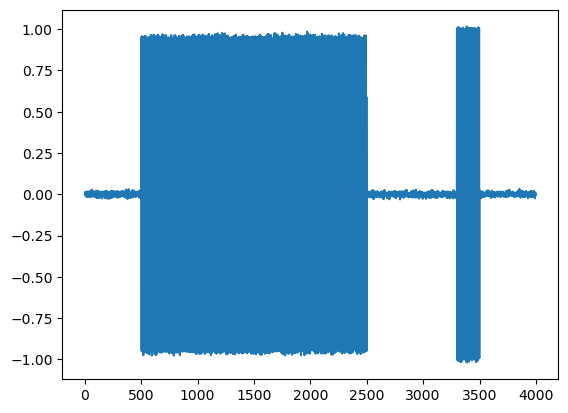

In [ ]:
plt.figure()
plt.plot(x[0].cpu())
plt.show()

In [ ]:
stride = 250
support = 2_000
epochs = 100_000
lr = 10
win_min = 100
threshold = .5
patience = 9
win_length = 500
factor = 0.1

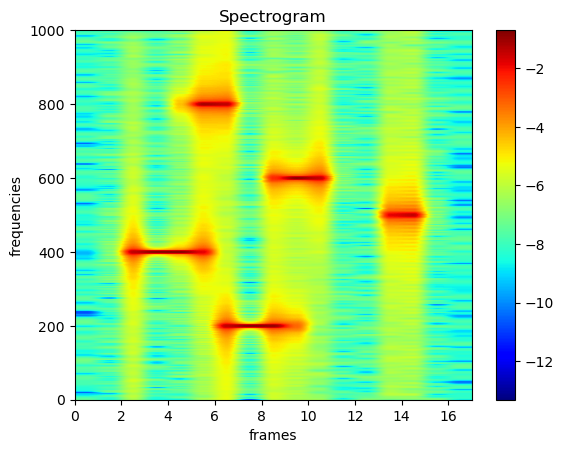

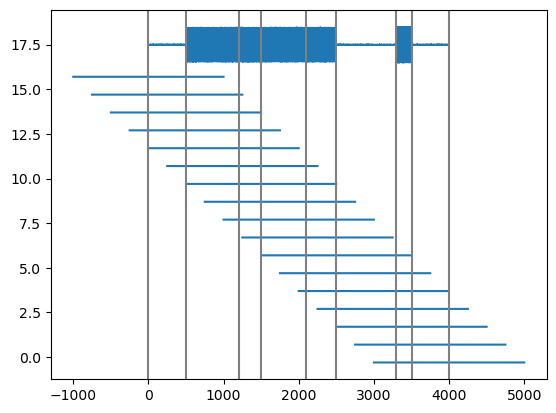

In [ ]:
dstft = DSTFT(
    x,
    win_length=577,
    support=support,
    stride=stride,
    win_requires_grad=False,
    stride_requires_grad=False,
)
spec, *_ = dstft(x)
dstft.plot(spec, x, weights=False, bar=True, marklist=mark_list)

1212


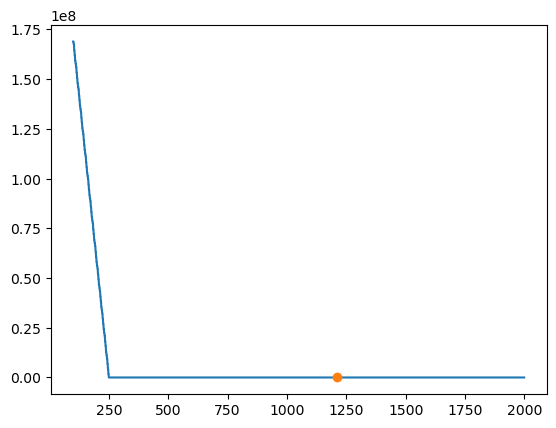

In [ ]:
loss_function = []
min_err = 100
min_win = 0

for win_length in range(100, support, 1):
    dstft = DSTFT(
        x,
        win_length=win_length,
        support=support,
        stride=stride,
        win_requires_grad=False,
        stride_requires_grad=False,
        win_p=None,
        stride_p=None,
    )
    spec, stft = dstft(x)
    x_hat = dstft.inverse_dstft(stft)
    err = 1_000_000_000 * F.mse_loss(x, x_hat)

    if err < min_err:
        min_err = err
        min_win = win_length
    loss_function.append(err.cpu())

print(min_win)
plt.plot(range(100, support, 1), loss_function, label='loss')
plt.plot(min_win, min_err.cpu(), 'o', label='min')

/home/maxime/miniforge3/envs/dstft/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


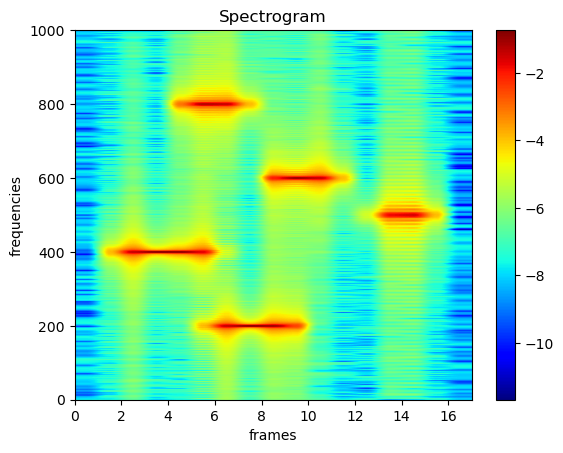

nb of epochs: 200, 855.778564453125, 5.792246341705322


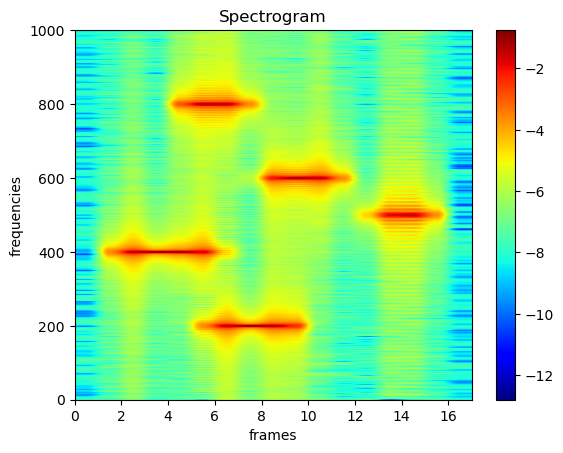

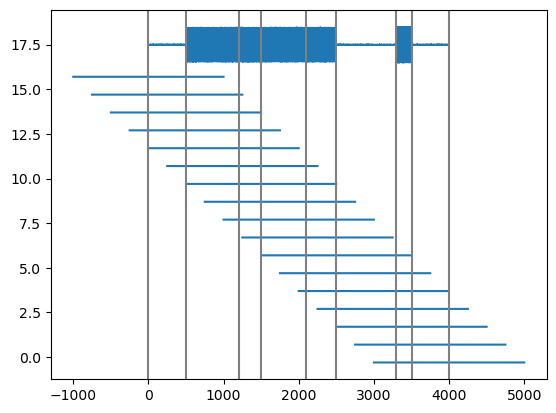

In [ ]:
dstft = DSTFT(
    x,
    win_length=800,
    support=support,
    stride=stride,
    win_requires_grad=True,
    stride_requires_grad=False,
    win_p=None,
    stride_p=None,
)
params = [{"params": dstft.win_length, "lr": lr}]
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=opt, mode="min", factor=0.1, patience=99, verbose=True,
)

min_err = 100
min_win = 0

spec, stft = dstft(x)
dstft.plot(spec, x, bar=True, wins=False, weights=False)

for epoch in range(epochs):
    opt.zero_grad()
    spec, stft = dstft(x)
    x_hat = dstft.inverse_dstft(stft)
    err = 1_000_000_000 * F.mse_loss(x, x_hat)    
    err.backward()
    opt.step()
    sch.step(err)

    if opt.param_groups[0]["lr"] < threshold:
        break
print(f"nb of epochs: {epoch}, {dstft.win_length.mean().item()}, {err.item()}")
dstft.plot(spec, x, wins=True, weights=False, bar=True, marklist=mark_list)

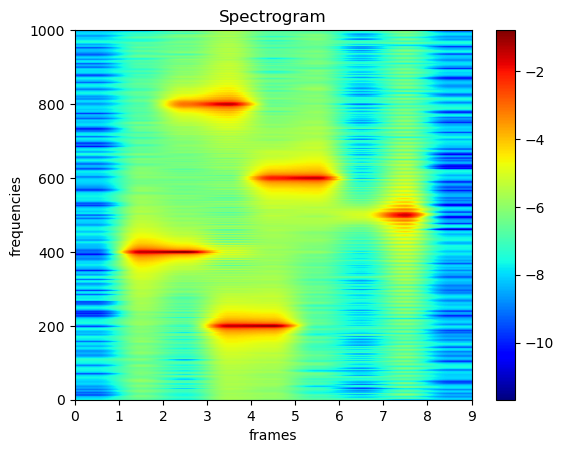

nb of epochs: 200, 528.5953369140625, 0.005792808718979359


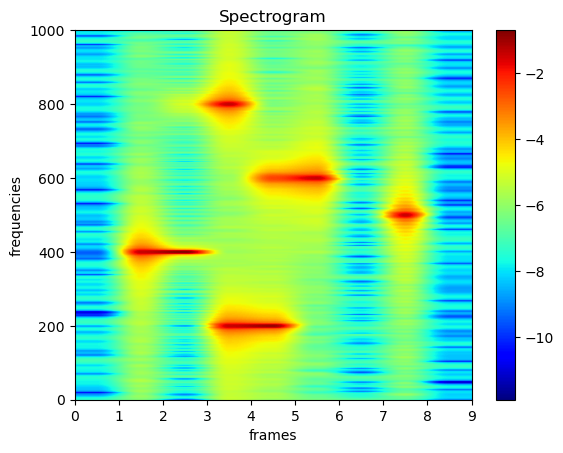

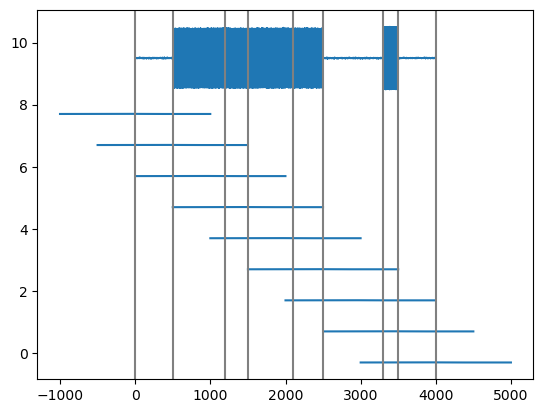

In [ ]:
dstft = DSTFT(
    x,
    win_length=800,
    support=support,
    stride=500,
    win_requires_grad=True,
    stride_requires_grad=False,
    win_p=None,
    stride_p=None,
)
params = [{"params": dstft.win_length, "lr": lr}]
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=opt, mode="min", factor=0.1, patience=99, verbose=True,
)

min_err = 100
min_win = 0

spec, stft = dstft(x)
dstft.plot(spec, x, bar=True, wins=False, weights=False)

for epoch in range(epochs):
    opt.zero_grad()
    spec, stft = dstft(x)
    x_hat = dstft.inverse_dstft(stft)
    err = 1_000_000 * F.mse_loss(x, x_hat)    
    err.backward()
    opt.step()
    sch.step(err)

    if opt.param_groups[0]["lr"] < threshold:
        break
print(f"nb of epochs: {epoch}, {dstft.win_length.mean().item()}, {err.item()}")
dstft.plot(spec, x, wins=True, weights=False, bar=True, marklist=mark_list)

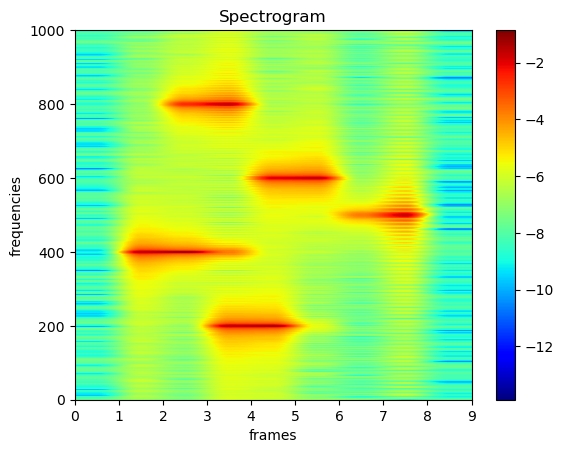

tensor(1000., grad_fn=<MeanBackward0>) 5.792246156488545e-06
nb of epochs: 2000, 887.4358520507812, 0.005792658776044846


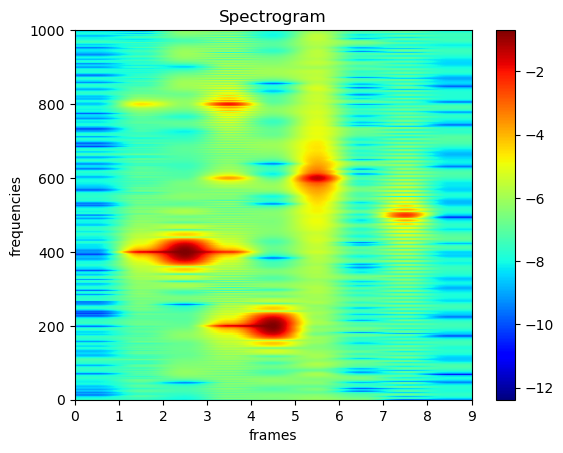

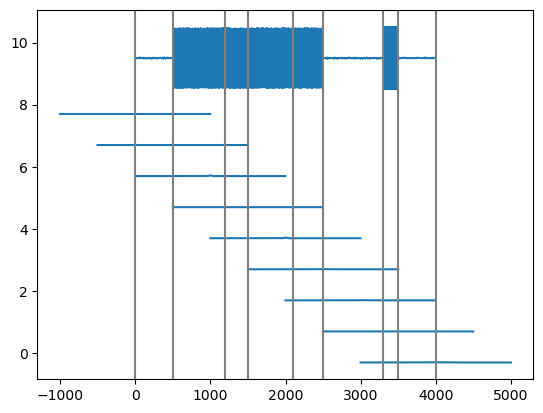

In [ ]:
dstft = DSTFT(
    x,
    win_length=1000,
    support=support,
    stride=500,
    win_requires_grad=True,
    stride_requires_grad=True,
    win_p="t",
    stride_p="t",
)
params = [{"params": dstft.win_length, "lr": 10}]
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=opt, mode="min", factor=0.1, patience=999, verbose=True,
)


spec, stft = dstft(x)
dstft.plot(spec, x, bar=True, wins=False, weights=False)
x_hat = dstft.inverse_dstft(stft)
err = 1_000 * F.mse_loss(x, x_hat)
print(dstft.win_length.mean(), err.item())

for epoch in range(epochs):
    opt.zero_grad()
    spec, stft = dstft(x)
    x_hat = dstft.inverse_dstft(stft)
    err = 1_000_000 * F.mse_loss(x, x_hat)    
    err.backward()
    opt.step()
    sch.step(err)

    if opt.param_groups[0]["lr"] < threshold:
        break

print(f"nb of epochs: {epoch}, {dstft.win_length.mean().item()}, {err.item()}")
dstft.plot(spec, x, wins=True, weights=False, bar=True, marklist=mark_list)

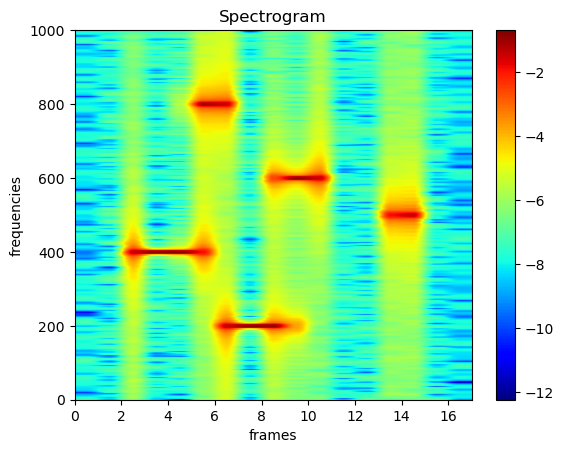

1999 0.00579224806278944
nb of epochs: 200, 500.0, 0.00579224806278944


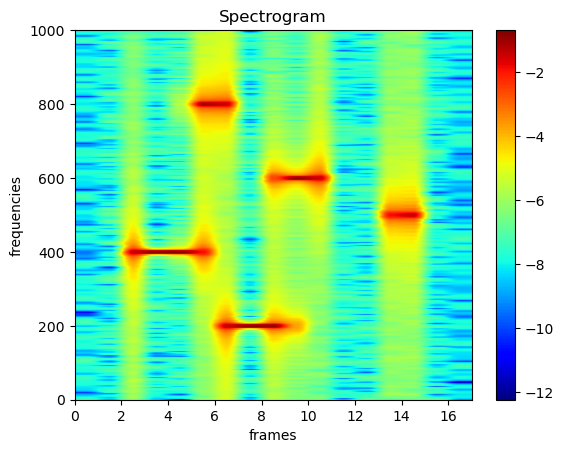

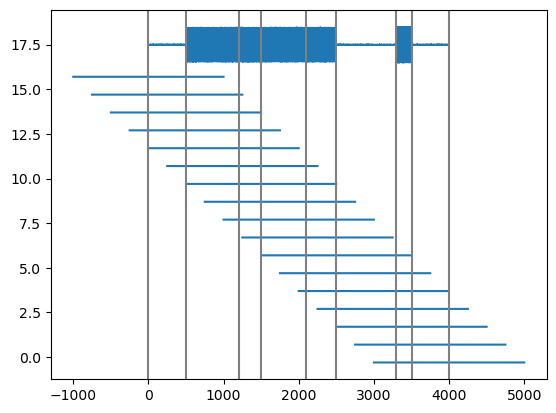

In [ ]:
dstft = DSTFT(
    x,
    win_length=500,
    support=support,
    stride=stride,
    win_requires_grad=False,
    stride_requires_grad=True,
    win_p="t",
    stride_p="t",
)
params = [{"params": dstft.win_length, "lr": lr}]
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=opt, mode="min", factor=0.1, patience=99, verbose=True,
)


spec, stft = dstft(x)
dstft.plot(spec, x, bar=True, wins=False, weights=False)
x_hat = dstft.inverse_dstft(stft)
err = 1_000_000 * F.mse_loss(x, x_hat)
print(win_length, err.item())

for epoch in range(epochs):
    opt.zero_grad()
    spec, stft = dstft(x)
    x_hat = dstft.inverse_dstft(stft)
    err = 1_000_000 * F.mse_loss(x, x_hat)    
    err.backward()
    opt.step()
    sch.step(err)

    if opt.param_groups[0]["lr"] < threshold:
        break

print(f"nb of epochs: {epoch}, {dstft.win_length.mean().item()}, {err.item()}")
dstft.plot(spec, x, wins=True, weights=False, bar=True, marklist=mark_list)